<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/06_Genomics/Predicting_transcription_factor_binding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem - Prediction transcription factor (FT) binding:** TFs are proteins that bind to DNA. When they bind, they influence the probability of nearby genes being transcribed into RNA.

*But how does a TF know where to bind?*

**Aproach in this project - A convolutional model for TF binding:** 
- Using experimental data on a particular TF called JUND.
- Particular kind of cell called HepG2.
- To keep things manageable, we only include data from chromosome 22 (50 million bases long).
- The full chromosome has been split up into short segments (101 bases long) and each segment has been labeled to indicate whether it does or does not include a site where JUND binds,
- we will try to train a model that predicts those labels based on the sequence of each segment.

Note: If you want to train the model, you should enable GPU.

## Set up

In [ ]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

## Dataset

Create directories to load datasets

In [ ]:
!mkdir 'tfbinding'
%cd 'tfbinding/'
!mkdir 'train_dataset'
!mkdir 'valid_dataset'

/content/tfbinding


IMPORTANT TO DO:


1.   Download [train_set](https://downgit.github.io/#/home?url=https://github.com/deepchem/DeepLearningLifeSciences/tree/master/Chapter06/train_dataset)
2.   Download [valid_set](https://downgit.github.io/#/home?url=https://github.com/deepchem/DeepLearningLifeSciences/tree/master/Chapter06/valid_dataset)
3.   Upload files into `tfbinding/` into corresponding dataset.
4. Wait until all files are loaded.



In [ ]:
# Load data using DiskDataset
train = dc.data.DiskDataset('train_dataset')
valid = dc.data.DiskDataset('valid_dataset')

In [ ]:
print('Train shape: {}'.format(train.get_data_shape))
print('Valid shape: {}'.format(valid.get_data_shape))

Train shape: <bound method DiskDataset.get_data_shape of <DiskDataset X.shape: (276216, 101, 4), y.shape: (276216, 1), w.shape: (276216, 1), task_names: [0]>>
Valid shape: <bound method DiskDataset.get_data_shape of <DiskDataset X.shape: (34527, 101, 4), y.shape: (34527, 1), w.shape: (34527, 1), task_names: [0]>>


## Creating the model (Convolutional Neural Network - 1D)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [ ]:
segment_len = 101
num_bases = 4
batch_size = 1000

input_shape = (segment_len, num_bases)

In [ ]:
# Creating Keras model

input = tf.keras.Input(shape=input_shape)
cnn = input

for _ in range(3):
  cnn = layers.Conv1D(filters=15, kernel_size=10, activation='relu', padding='same')(cnn)
  cnn = layers.Dropout(rate=0.5)(cnn)

cnn = layers.Flatten()(cnn)
logits = layers.Dense(units=1)(cnn)
output = layers.Activation('sigmoid')(logits)

keras_model = tf.keras.Model(inputs=input, outputs=[output, logits])

keras_model.summary()
print(type(keras_model).__name__)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 101, 15)           615       
_________________________________________________________________
dropout (Dropout)            (None, 101, 15)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 15)           2265      
_________________________________________________________________
dropout_1 (Dropout)          (None, 101, 15)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 101, 15)           2265      
_________________________________________________________________
dropout_2 (Dropout)          (None, 101, 15)           0     

In [ ]:
# Creating Deep Chem model
model = dc.models.KerasModel(
  model=keras_model, 
  loss=dc.models.losses.SigmoidCrossEntropy(),
  output_types=['prediction', 'loss'],
  batch_size=batch_size
)

## Training

In [ ]:
from tqdm import tqdm

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
num_epochs = 6

# Test performance in training and validation dataset
train_roc_auc_scores = []
valid_roc_auc_scores = []

# 60 epochs in total

for _ in tqdm(range(10)):
  model.fit(train, nb_epoch=num_epochs)
  train_score = model.evaluate(train, [metric])
  print('\n', train_score)
  valid_score = model.evaluate(valid, [metric])
  # print('\n', valid_score)

  train_roc_auc_scores.append(train_score['roc_auc_score'])
  valid_roc_auc_scores.append(valid_score['roc_auc_score'])

In [ ]:
print(train_roc_auc_scores[-1])
print(valid_roc_auc_scores[-1])

0.8216506583981555
0.7319686765508029


## Graphing the performance

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

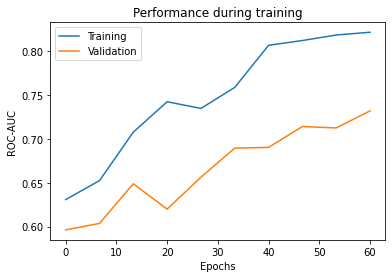

In [ ]:
x = np.linspace(0, 60, 10)

plt.title('Performance during training')
plt.plot(x, train_roc_auc_scores, label='Training')
plt.plot(x, valid_roc_auc_scores, label='Validation')

plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')

plt.legend()
plt.show()

**Important to know**: There are fundamental limits to how well this model can ever work.
The only input it looks at is the DNA sequence, and TF binding also depends on lots
of other factors: accessibility, methylation, shape, the presence of other molecules, etc.
Any model that ignores those factors will be limited in how accurate its predictions
can ever be.